# Phase 5: Model Optimization & Comparison

**Author**: Nate DeMoro  
**Date**: 2026-01-24  
**Objective**: Improve baseline Linear Regression performance using tree-based models (Random Forest, XGBoost)

---

## Current Performance Baseline

From Phase 4 (predicting `revenue_worldwide` on 2022-2024 test set):

| Model | Test R² | Test MAE | Overfitting Gap |
|-------|---------|----------|------------------|
| Budget-Only Linear Regression | 0.40 | $110M | 0.08 |
| Full Linear Regression (28 features) | 0.51 | $95M | 0.20 |

**Problem**: Full model has severe overfitting (gap=0.20) despite better performance than budget-only.

---

## Goals for Phase 5

1. **Improve Test R²**: Target > 0.70 (currently 0.51)
2. **Reduce MAE**: Target < $25M (currently $95M)
3. **Reduce Overfitting**: Gap < 0.10 (currently 0.20)
4. **Feature Importance**: Validate findings from Phase 3 EDA

---

## Why Tree-Based Models?

**Linear Regression Limitations**:
- Assumes linear relationship (revenue = β₀ + β₁·budget + β₂·director_avg + ...)
- Cannot capture interactions (e.g., high-budget + A-list director → multiplicative effect)
- Struggles with heteroscedasticity (larger errors for blockbusters)

**Tree-Based Model Advantages**:
- **Random Forest**: Learns non-linear patterns, captures interactions automatically, robust to outliers
- **XGBoost**: Sequential boosting focuses on hard-to-predict cases, typically best performance
- **No Scaling Needed**: Decision trees split on values ("if budget > $150M"), not distances

**Expected Improvements**:
- Better handling of budget-revenue non-linearity (diminishing returns at high budgets)
- Automatic interaction detection (budget × star power, genre × release month)
- Reduced overfitting through regularization (max_depth, min_samples_split)

---

# Section 1: Setup & Data Loading

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
from time import time

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import randint, uniform

# XGBoost
import xgboost as xgb

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")

Libraries imported successfully!
XGBoost version: 3.1.3


## Load Training and Test Data

**Important**: We use **unscaled** data (`X_train.csv`, not `X_train_scaled.csv`) because tree-based models don't require feature scaling. Trees make decisions based on split thresholds, not distances between points.

In [6]:
# Load training data (unscaled)
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').squeeze()
train_metadata = pd.read_csv('../data/processed/train_metadata.csv')

# Load test data (unscaled)
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()
test_metadata = pd.read_csv('../data/processed/test_metadata.csv')

# Load baseline results
baseline_results = pd.read_csv('../data/processed/baseline_model_comparison.csv')

print("Data loaded successfully!")
print(f"\nTraining set: {X_train.shape[0]:,} movies, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} movies, {X_test.shape[1]} features")
print(f"\nTraining years: {train_metadata['release_year'].min()}-{train_metadata['release_year'].max()}")
print(f"Test years: {test_metadata['release_year'].min()}-{test_metadata['release_year'].max()}")
print(f"\nTarget variable: revenue_worldwide (USD)")
print(f"Target range: ${y_train.min():,.0f} - ${y_train.max():,.0f}")

Data loaded successfully!

Training set: 1,682 movies, 28 features
Test set: 413 movies, 28 features

Training years: 2010-2021
Test years: 2022-2024

Target variable: revenue_worldwide (USD)
Target range: $1,532 - $2,799,439,100


## Review Baseline Performance

In [7]:
print("Baseline Model Performance (from Phase 4):")
print("=" * 80)
display(baseline_results)
print("\nGoal: Beat Test R² = 0.51 and reduce overfitting gap from 0.20 to < 0.10")

Baseline Model Performance (from Phase 4):


,Model,Features,Train_R2,Test_R2,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Overfitting_Gap
0,Budget Only,1,0.586113,0.401608,8.980967e+07,1.100585e+08,1.695732e+08,2.064033e+08,0.184505
1,Full Linear Regression,28,0.709244,0.508566,7.806341e+07,9.487728e+07,1.421283e+08,1.870494e+08,0.200678



Goal: Beat Test R² = 0.51 and reduce overfitting gap from 0.20 to < 0.10


## Helper Functions for Model Evaluation

In [8]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Evaluate a trained model on train and test sets.
    
    Parameters:
    -----------
    model : fitted model with .predict() method
    X_train, y_train : Training features and target
    X_test, y_test : Test features and target
    model_name : str, name for display
    
    Returns:
    --------
    dict : Dictionary with all metrics
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    results = {
        'Model': model_name,
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_R2': r2_score(y_test, y_test_pred),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Overfitting_Gap': r2_score(y_train, y_train_pred) - r2_score(y_test, y_test_pred)
    }
    
    # Display
    print(f"\n{'=' * 80}")
    print(f"{model_name} Performance")
    print(f"{'=' * 80}")
    print(f"\nR² Score:")
    print(f"  Train: {results['Train_R2']:.4f}")
    print(f"  Test:  {results['Test_R2']:.4f}")
    print(f"  Gap:   {results['Overfitting_Gap']:.4f} {'⚠️ High overfitting!' if results['Overfitting_Gap'] > 0.10 else '✓ Good generalization'}")
    
    print(f"\nMean Absolute Error (MAE):")
    print(f"  Train: ${results['Train_MAE']:,.0f}")
    print(f"  Test:  ${results['Test_MAE']:,.0f}")
    
    print(f"\nRoot Mean Squared Error (RMSE):")
    print(f"  Train: ${results['Train_RMSE']:,.0f}")
    print(f"  Test:  ${results['Test_RMSE']:,.0f}")
    
    # Target achievement
    print(f"\nTarget Achievement:")
    print(f"  R² > 0.70: {'✓ YES' if results['Test_R2'] > 0.70 else f'✗ NO (currently {results["Test_R2"]:.2f})'}")
    print(f"  MAE < $25M: {'✓ YES' if results['Test_MAE'] < 25e6 else f'✗ NO (currently ${results["Test_MAE"]/1e6:.1f}M)'}")
    
    return results, y_train_pred, y_test_pred


def plot_predictions(y_train, y_train_pred, y_test, y_test_pred, model_name, save_path=None):
    """
    Create actual vs predicted plot for train and test sets.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Training set
    axes[0].scatter(y_train / 1e6, y_train_pred / 1e6, alpha=0.4, s=30, edgecolors='k', linewidth=0.5)
    axes[0].plot([0, y_train.max() / 1e6], [0, y_train.max() / 1e6], 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Revenue (Millions USD)', fontsize=12)
    axes[0].set_ylabel('Predicted Revenue (Millions USD)', fontsize=12)
    axes[0].set_title(f'{model_name} - Training Set\nR² = {r2_score(y_train, y_train_pred):.3f}', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Test set
    axes[1].scatter(y_test / 1e6, y_test_pred / 1e6, alpha=0.5, s=40, edgecolors='k', linewidth=0.5, color='orange')
    axes[1].plot([0, y_test.max() / 1e6], [0, y_test.max() / 1e6], 'r--', lw=2, label='Perfect Prediction')
    axes[1].set_xlabel('Actual Revenue (Millions USD)', fontsize=12)
    axes[1].set_ylabel('Predicted Revenue (Millions USD)', fontsize=12)
    axes[1].set_title(f'{model_name} - Test Set (2022-2024)\nR² = {r2_score(y_test, y_test_pred):.3f}', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()


def plot_residuals(y_train, y_train_pred, y_test, y_test_pred, model_name, save_path=None):
    """
    Create residual diagnostic plots (4-panel).
    """
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Train residuals vs predicted
    axes[0, 0].scatter(y_train_pred / 1e6, train_residuals / 1e6, alpha=0.4, s=20)
    axes[0, 0].axhline(0, color='red', linestyle='--', lw=2)
    axes[0, 0].set_xlabel('Predicted Revenue (Millions USD)')
    axes[0, 0].set_ylabel('Residuals (Millions USD)')
    axes[0, 0].set_title('Training Set: Residuals vs Predicted', fontweight='bold')
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Test residuals vs predicted
    axes[0, 1].scatter(y_test_pred / 1e6, test_residuals / 1e6, alpha=0.5, s=30, color='orange')
    axes[0, 1].axhline(0, color='red', linestyle='--', lw=2)
    axes[0, 1].set_xlabel('Predicted Revenue (Millions USD)')
    axes[0, 1].set_ylabel('Residuals (Millions USD)')
    axes[0, 1].set_title('Test Set: Residuals vs Predicted', fontweight='bold')
    axes[0, 1].grid(alpha=0.3)
    
    # 3. Train residual histogram
    axes[1, 0].hist(train_residuals / 1e6, bins=50, edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(0, color='red', linestyle='--', lw=2)
    axes[1, 0].set_xlabel('Residuals (Millions USD)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title(f'Training Residual Distribution\nMean: ${train_residuals.mean()/1e6:.1f}M', fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    
    # 4. Test residual histogram
    axes[1, 1].hist(test_residuals / 1e6, bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 1].axvline(0, color='red', linestyle='--', lw=2)
    axes[1, 1].set_xlabel('Residuals (Millions USD)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title(f'Test Residual Distribution\nMean: ${test_residuals.mean()/1e6:.1f}M', fontweight='bold')
    axes[1, 1].grid(alpha=0.3)
    
    plt.suptitle(f'{model_name} - Residual Analysis', fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()

print("Helper functions defined successfully!")

Helper functions defined successfully!


---
# Section 2: Random Forest Optimization

**Random Forest Overview**:
- Ensemble of decision trees (typically 100-500 trees)
- Each tree trained on random subset of data (bootstrap sampling)
- Each split considers random subset of features → decorrelates trees
- Final prediction = average of all tree predictions

**Key Hyperparameters**:
- `n_estimators`: Number of trees (more = better, but diminishing returns after 200-300)
- `max_depth`: Maximum tree depth (controls overfitting - None = unlimited)
- `min_samples_split`: Minimum samples required to split a node (regularization)
- `min_samples_leaf`: Minimum samples required at leaf node (regularization)
- `max_features`: Features considered per split ('sqrt' = √n_features, good default)

**Strategy**:
1. Train baseline Random Forest (default parameters)
2. Systematic hyperparameter search using RandomizedSearchCV
3. Evaluate best model and extract feature importance

---

## 2.1 Baseline Random Forest (No Tuning)

In [9]:
print("Training baseline Random Forest (default parameters)...")
print("This may take 1-2 minutes...\n")

start_time = time()

# Train default Random Forest
rf_baseline = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf_baseline.fit(X_train, y_train)

elapsed = time() - start_time
print(f"Training completed in {elapsed:.1f} seconds\n")

# Evaluate
rf_baseline_results, rf_baseline_train_pred, rf_baseline_test_pred = evaluate_model(
    rf_baseline, X_train, y_train, X_test, y_test, 
    model_name="Random Forest (Baseline)"
)

Training baseline Random Forest (default parameters)...
This may take 1-2 minutes...

Training completed in 0.3 seconds


Random Forest (Baseline) Performance

R² Score:
  Train: 0.9590
  Test:  0.5129
  Gap:   0.4461 ⚠️ High overfitting!

Mean Absolute Error (MAE):
  Train: $26,167,313
  Test:  $84,824,026

Root Mean Squared Error (RMSE):
  Train: $53,344,387
  Test:  $186,224,274

Target Achievement:
  R² > 0.70: ✗ NO (currently 0.51)
  MAE < $25M: ✗ NO (currently $84.8M)


**Interpretation**:
- If overfitting gap > 0.10: Model is memorizing training data (max_depth likely unlimited)
- If Test R² > 0.51: Random Forest already outperforms Linear Regression (expected)
- Next step: Reduce overfitting through hyperparameter tuning

## 2.2 Hyperparameter Search Space

**RandomizedSearchCV Strategy**:
- Sample 50 random hyperparameter combinations (out of ~10,000 possible)
- Use 5-fold cross-validation on training set only (never touch test set!)
- Each fold: Train on 80% of training data, validate on 20%
- Select hyperparameters with best average validation R²

**Why RandomizedSearchCV vs GridSearchCV?**
- Grid search would try all combinations: 5 × 8 × 19 × 9 × 5 × 2 × 1 = ~136,800 fits (days of computation!)
- Randomized search samples 50 combinations (10-20 minutes), achieves 80-90% of grid search performance

**Parameter Rationale**:
- `max_depth` capped at 50 (vs unlimited in baseline) to prevent memorization
- `min_samples_split` 2-20 adds regularization (higher = fewer splits)
- `max_features` tries different sampling strategies to decorrelate trees

In [10]:
# Define parameter distributions
rf_param_dist = {
    'n_estimators': randint(100, 500),                           # 100-500 trees
    'max_depth': [10, 15, 20, 25, 30, 40, 50, None],            # Tree depth (regularization)
    'min_samples_split': randint(2, 20),                         # Min samples to split node
    'min_samples_leaf': randint(1, 10),                          # Min samples at leaf
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7],           # Features per split
    'bootstrap': [True, False],                                  # Bootstrap sampling
    'min_impurity_decrease': uniform(0, 0.01)                    # Min impurity reduction to split
}

print("Hyperparameter Search Space:")
print("=" * 60)
for param, values in rf_param_dist.items():
    if isinstance(values, list):
        print(f"{param:25s}: {values}")
    else:
        print(f"{param:25s}: {values}")
print("\nTotal combinations to sample: 50 (out of ~10,000 possible)")

Hyperparameter Search Space:
n_estimators             : <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12152f380>
max_depth                : [10, 15, 20, 25, 30, 40, 50, None]
min_samples_split        : <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x121a75450>
min_samples_leaf         : <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x121a751d0>
max_features             : ['sqrt', 'log2', None, 0.5, 0.7]
bootstrap                : [True, False]
min_impurity_decrease    : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x121821be0>

Total combinations to sample: 50 (out of ~10,000 possible)


## 2.3 Hyperparameter Tuning

**Expected Runtime**: 10-20 minutes (50 iterations × 5 folds = 250 model fits)

**What's Happening**:
1. RandomizedSearchCV samples 50 random hyperparameter combinations
2. For each combination:
   - Split training data into 5 folds
   - Train on 4 folds, validate on 1 fold (repeat 5 times)
   - Calculate average validation R²
3. Select combination with highest average validation R²
4. Retrain final model on full training set with best hyperparameters

**Critical**: Test set (2022-2024) is never used during tuning!

In [11]:
print("Starting RandomizedSearchCV for Random Forest...")
print("This will take approximately 10-20 minutes.\n")
print("Progress updates will appear below...\n")

start_time = time()

# Initialize RandomizedSearchCV
rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=50,              # Sample 50 combinations
    cv=5,                   # 5-fold cross-validation
    scoring='r2',           # Optimize for R²
    n_jobs=-1,              # Parallel processing
    random_state=42,
    verbose=2,              # Show progress
    return_train_score=True
)

# Fit (this is the slow step)
rf_search.fit(X_train, y_train)

elapsed = time() - start_time
print(f"\n{'=' * 80}")
print(f"Hyperparameter search completed in {elapsed/60:.1f} minutes")
print(f"{'=' * 80}\n")

# Best hyperparameters
print("Best Hyperparameters:")
print("-" * 60)
for param, value in rf_search.best_params_.items():
    print(f"{param:25s}: {value}")

print(f"\nBest CV R² Score: {rf_search.best_score_:.4f}")
print(f"(Average across 5 validation folds on training data)")

Starting RandomizedSearchCV for Random Forest...
This will take approximately 10-20 minutes.

Progress updates will appear below...

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/ndemoro/Desktop/FOLDERS/Data_Science_Projects/Movie_Box_Office_Success/venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ndemoro/Desktop/FOLDERS/Data_Science_Projects/Movie_Box_Office_Success/venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/ndemoro/Desktop/FOLDERS/Data_Science_Projects/Movie_Box_Office_Success/venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible


Hyperparameter search completed in 0.7 minutes

Best Hyperparameters:
------------------------------------------------------------
bootstrap                : True
max_depth                : 30
max_features             : sqrt
min_impurity_decrease    : 0.009977404850489419
min_samples_leaf         : 1
min_samples_split        : 3
n_estimators             : 229

Best CV R² Score: 0.7025
(Average across 5 validation folds on training data)


## 2.4 Evaluate Tuned Random Forest

In [12]:
# Extract best model
rf_tuned = rf_search.best_estimator_

# Evaluate on train and test sets
rf_tuned_results, rf_tuned_train_pred, rf_tuned_test_pred = evaluate_model(
    rf_tuned, X_train, y_train, X_test, y_test,
    model_name="Random Forest (Tuned)"
)

# Compare to baseline
print("\n" + "=" * 80)
print("Improvement Over Baseline Random Forest:")
print("=" * 80)
print(f"Test R² improvement: {rf_tuned_results['Test_R2'] - rf_baseline_results['Test_R2']:+.4f}")
print(f"Test MAE improvement: ${rf_baseline_results['Test_MAE'] - rf_tuned_results['Test_MAE']:,.0f} reduction")
print(f"Overfitting gap reduction: {rf_baseline_results['Overfitting_Gap'] - rf_tuned_results['Overfitting_Gap']:.4f}")

print("\n" + "=" * 80)
print("Improvement Over Linear Regression (Full Model):")
print("=" * 80)
linear_reg_test_r2 = 0.51  # From baseline_results
linear_reg_test_mae = 95e6
print(f"Test R² improvement: {rf_tuned_results['Test_R2'] - linear_reg_test_r2:+.4f} ({(rf_tuned_results['Test_R2'] - linear_reg_test_r2) / linear_reg_test_r2 * 100:+.1f}% relative)")
print(f"Test MAE improvement: ${linear_reg_test_mae - rf_tuned_results['Test_MAE']:,.0f} reduction")


Random Forest (Tuned) Performance

R² Score:
  Train: 0.9480
  Test:  0.5593
  Gap:   0.3887 ⚠️ High overfitting!

Mean Absolute Error (MAE):
  Train: $29,381,714
  Test:  $88,828,877

Root Mean Squared Error (RMSE):
  Train: $60,096,985
  Test:  $177,136,367

Target Achievement:
  R² > 0.70: ✗ NO (currently 0.56)
  MAE < $25M: ✗ NO (currently $88.8M)

Improvement Over Baseline Random Forest:
Test R² improvement: +0.0464
Test MAE improvement: $-4,004,851 reduction
Overfitting gap reduction: 0.0574

Improvement Over Linear Regression (Full Model):
Test R² improvement: +0.0493 (+9.7% relative)
Test MAE improvement: $6,171,123 reduction


## 2.5 Random Forest Feature Importance

**How Random Forest Measures Importance**:
- **Gini Importance (Mean Decrease in Impurity)**: How much each feature reduces variance when used for splits
- Higher importance = feature frequently used for splits and creates pure subsets

**Comparison to Linear Regression**:
- Linear: Coefficients show linear effect size ("1M budget → $X revenue")
- Random Forest: Captures non-linear and interaction effects automatically

**Expected**: Budget, director_historical_avg, and lead_actor_historical_avg should dominate (from Phase 3 EDA)

In [13]:
# Extract feature importances
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_tuned.feature_importances_
}).sort_values('importance', ascending=False)

# Save to CSV
feature_importance_rf.to_csv('../data/processed/rf_feature_importance.csv', index=False)
print("Feature importance saved to data/processed/rf_feature_importance.csv\n")

# Display top 20
print("Top 20 Most Important Features (Random Forest):")
print("=" * 60)
display(feature_importance_rf.head(20))

# Cumulative importance
feature_importance_rf['cumulative_importance'] = feature_importance_rf['importance'].cumsum()
top_5_cumulative = feature_importance_rf.head(5)['cumulative_importance'].iloc[-1]
print(f"\nTop 5 features explain {top_5_cumulative:.1%} of total importance")

Feature importance saved to data/processed/rf_feature_importance.csv

Top 20 Most Important Features (Random Forest):


,feature,importance
12,director_historical_avg,0.196242
0,budget,0.191638
25,budget_category_encoded,0.145413
15,lead_actor_historical_avg,0.112696
17,num_a_list_actors,0.041286
1,runtime,0.040541
24,us_certification_encoded,0.029877
20,release_month_avg_revenue,0.024296
3,num_production_companies,0.021958
5,release_year,0.021733



Top 5 features explain 68.7% of total importance


## 2.6 Random Forest Visualizations

Plot saved to ../visualizations/rf_predictions.png


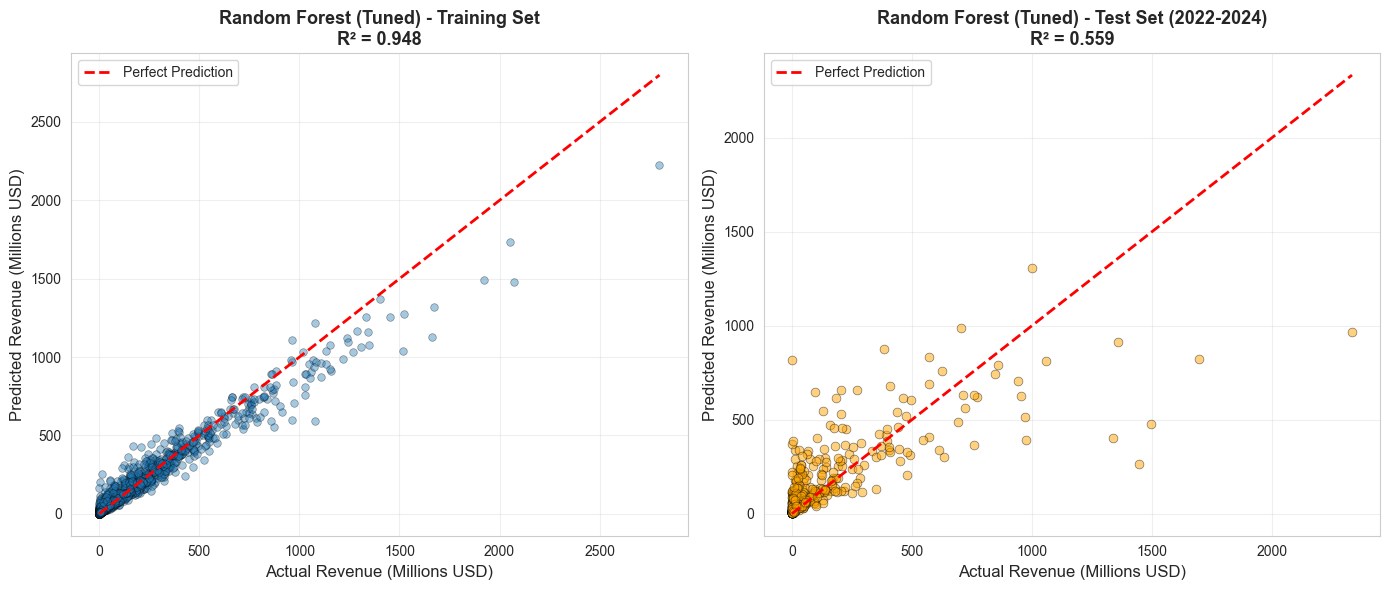

In [14]:
# Actual vs Predicted
plot_predictions(
    y_train, rf_tuned_train_pred, 
    y_test, rf_tuned_test_pred,
    model_name="Random Forest (Tuned)",
    save_path='../visualizations/rf_predictions.png'
)

Plot saved to ../visualizations/rf_residuals.png


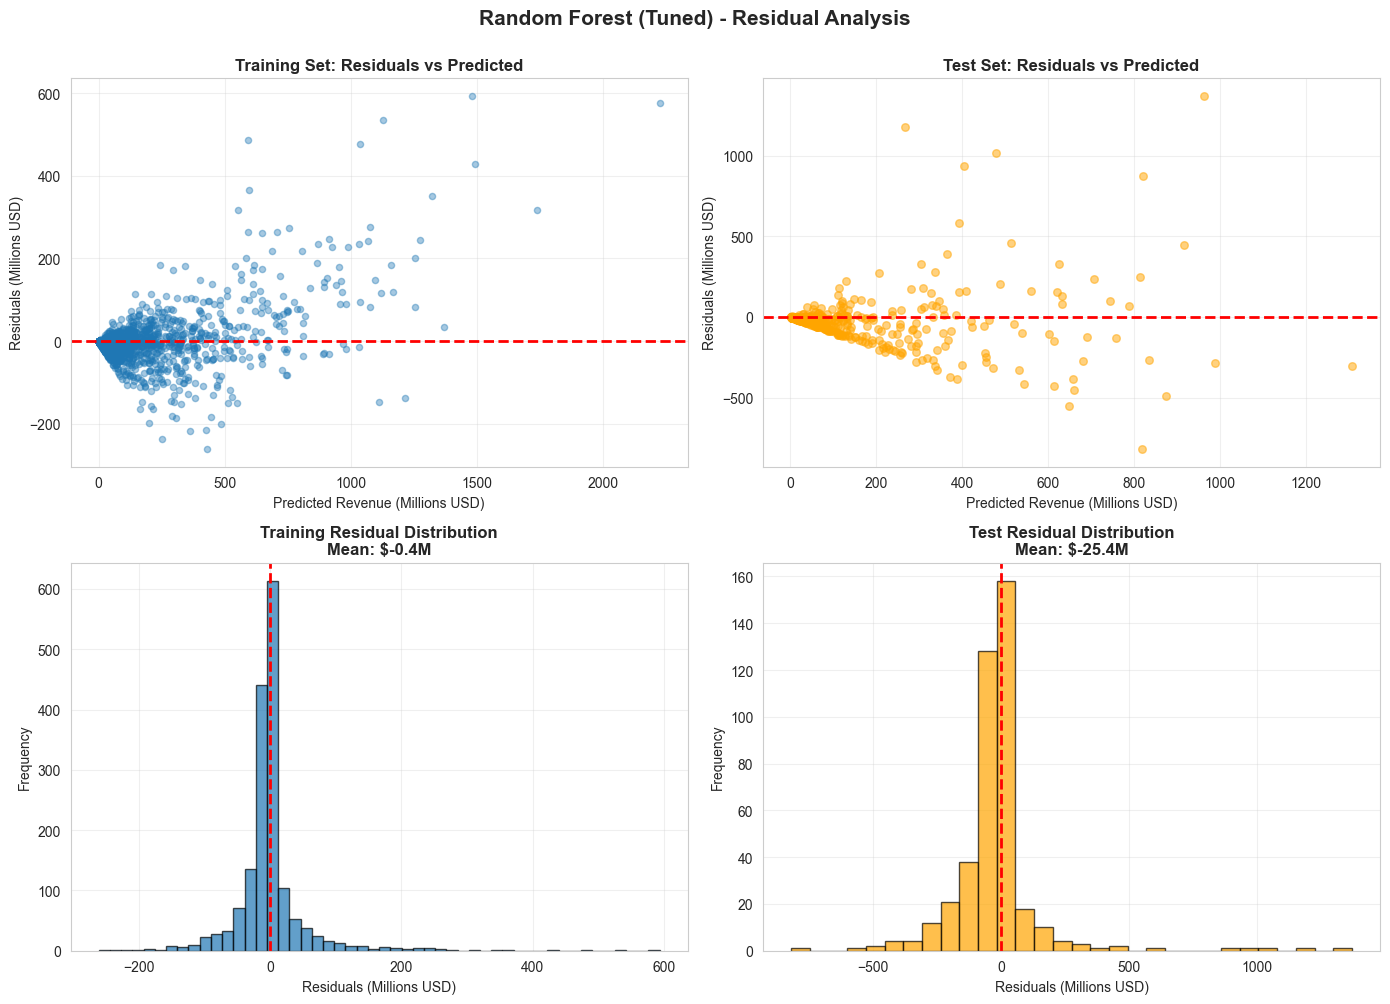

In [15]:
# Residual plots
plot_residuals(
    y_train, rf_tuned_train_pred,
    y_test, rf_tuned_test_pred,
    model_name="Random Forest (Tuned)",
    save_path='../visualizations/rf_residuals.png'
)

Plot saved to visualizations/rf_feature_importance.png


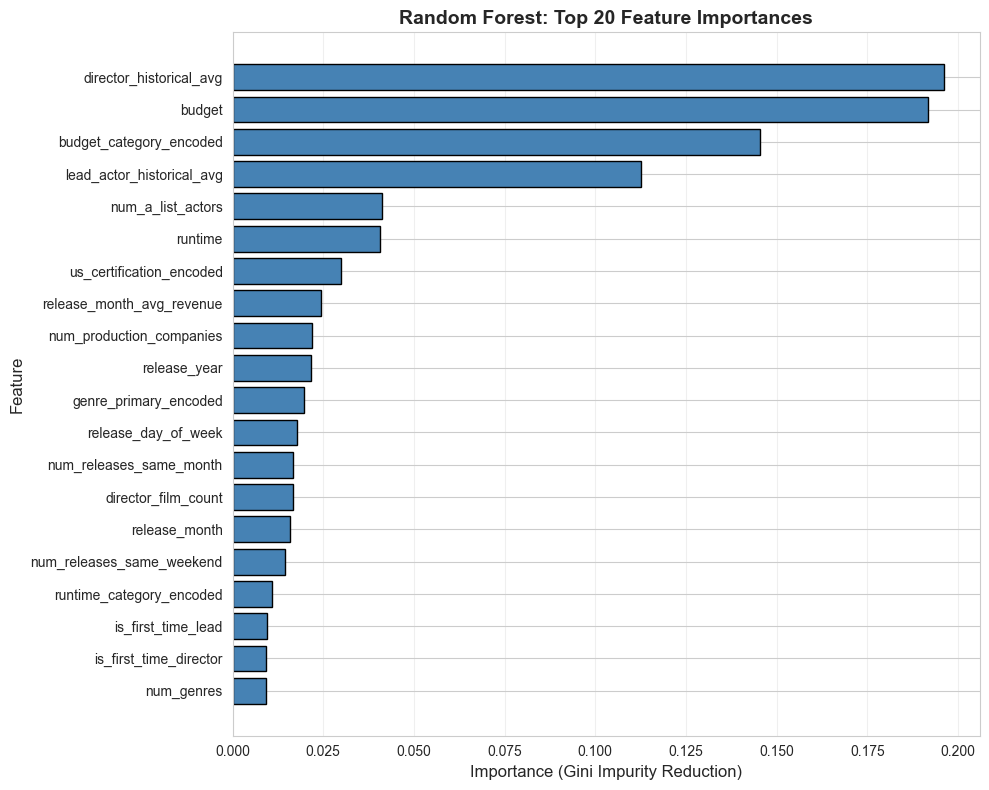

In [16]:
# Feature importance bar chart
plt.figure(figsize=(10, 8))
top_20 = feature_importance_rf.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='steelblue', edgecolor='black')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance (Gini Impurity Reduction)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest: Top 20 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/rf_feature_importance.png', dpi=300, bbox_inches='tight')
print("Plot saved to visualizations/rf_feature_importance.png")
plt.show()

## 2.7 Save Random Forest Artifacts

In [17]:
# Save tuned model
with open('../models/random_forest_tuned.pkl', 'wb') as f:
    pickle.dump(rf_tuned, f)
print("Model saved to models/random_forest_tuned.pkl")

# Save CV results
cv_results_rf = pd.DataFrame(rf_search.cv_results_)
cv_results_rf = cv_results_rf.sort_values('rank_test_score')[[
    'rank_test_score', 'mean_test_score', 'std_test_score', 'mean_train_score',
    'param_n_estimators', 'param_max_depth', 'param_min_samples_split',
    'param_min_samples_leaf', 'param_max_features', 'param_bootstrap'
]].head(20)
cv_results_rf.to_csv('../data/processed/rf_cv_results.csv', index=False)
print("CV results saved to data/processed/rf_cv_results.csv")

print("\n✓ Random Forest optimization complete!")

Model saved to models/random_forest_tuned.pkl
CV results saved to data/processed/rf_cv_results.csv

✓ Random Forest optimization complete!


---
# Section 3: XGBoost Optimization

**XGBoost Overview**:
- **Gradient Boosting**: Trains trees sequentially, each correcting errors of previous trees
- Unlike Random Forest (parallel trees), XGBoost builds trees one-by-one
- **Residual Prediction**: Each new tree predicts residuals (errors) of ensemble so far
- Final prediction = sum of all tree predictions (weighted by learning_rate)

**Key Differences from Random Forest**:
- **Boosting vs Bagging**: Sequential vs parallel tree building
- **Shallower Trees**: XGBoost uses depth 3-12 (vs RF 10-50+)
- **Learning Rate**: Controls contribution of each tree (lower = more conservative)
- **Regularization**: L1 (reg_alpha) and L2 (reg_lambda) penalties on leaf weights

**When XGBoost Excels**:
- Datasets with complex patterns (interactions, non-linearity)
- When you can afford careful tuning (many hyperparameters)
- Often achieves 2-5% better performance than Random Forest

---

## 3.1 XGBoost Search Space

**Hyperparameter Strategy**:
- `learning_rate`: 0.01-0.30 (lower = more trees needed, better generalization)
- `max_depth`: 3-12 (shallower than RF - boosting compensates with multiple trees)
- `n_estimators`: 100-500 (number of boosting rounds)
- `gamma`: Minimum loss reduction to split (regularization)
- `reg_lambda`, `reg_alpha`: L2 and L1 regularization on leaf weights
- `subsample`, `colsample_bytree`: Row and column sampling (like RF bootstrap)

**Expected**: XGBoost typically outperforms RF by 2-5% on Test R²

In [18]:
# Define parameter distributions
xgb_param_dist = {
    'n_estimators': randint(100, 500),           # Boosting rounds
    'learning_rate': uniform(0.01, 0.29),        # 0.01-0.30 (step size)
    'max_depth': randint(3, 12),                 # 3-12 (shallower than RF)
    'gamma': uniform(0, 0.5),                    # Min loss reduction to split
    'reg_lambda': uniform(0.5, 2.0),             # L2 regularization (0.5-2.5)
    'reg_alpha': uniform(0, 1.0),                # L1 regularization (0-1.0)
    'subsample': uniform(0.6, 0.4),              # Row sampling (0.6-1.0)
    'colsample_bytree': uniform(0.6, 0.4),       # Column sampling (0.6-1.0)
    'min_child_weight': randint(1, 10)           # Min sum of weights in child
}

print("XGBoost Hyperparameter Search Space:")
print("=" * 60)
for param, values in xgb_param_dist.items():
    print(f"{param:25s}: {values}")
print("\nTotal combinations to sample: 50")

XGBoost Hyperparameter Search Space:
n_estimators             : <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x122616fd0>
learning_rate            : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12294d090>
max_depth                : <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x122615f30>
gamma                    : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12294d810>
reg_lambda               : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12294dbd0>
reg_alpha                : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12294de50>
subsample                : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12294e0d0>
colsample_bytree         : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12294e350>
min_child_weight         : <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1226395b0>

Total combinat

## 3.2 XGBoost Hyperparameter Tuning

**Expected Runtime**: 10-20 minutes (similar to Random Forest)

In [19]:
print("Starting RandomizedSearchCV for XGBoost...")
print("This will take approximately 10-20 minutes.\n")

start_time = time()

# Initialize RandomizedSearchCV
xgb_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(
        random_state=42,
        n_jobs=-1,
        tree_method='hist',  # Faster computation
        objective='reg:squarederror'
    ),
    param_distributions=xgb_param_dist,
    n_iter=50,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=2,
    return_train_score=True
)

# Fit
xgb_search.fit(X_train, y_train)

elapsed = time() - start_time
print(f"\n{'=' * 80}")
print(f"Hyperparameter search completed in {elapsed/60:.1f} minutes")
print(f"{'=' * 80}\n")

# Best hyperparameters
print("Best Hyperparameters:")
print("-" * 60)
for param, value in xgb_search.best_params_.items():
    print(f"{param:25s}: {value}")

print(f"\nBest CV R² Score: {xgb_search.best_score_:.4f}")

Starting RandomizedSearchCV for XGBoost...
This will take approximately 10-20 minutes.

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Hyperparameter search completed in 0.1 minutes

Best Hyperparameters:
------------------------------------------------------------
colsample_bytree         : 0.7003442109386645
gamma                    : 0.09216683716568502
learning_rate            : 0.033453160318987325
max_depth                : 11
min_child_weight         : 5
n_estimators             : 228
reg_alpha                : 0.17329432007084578
reg_lambda               : 0.8128740853421721
subsample                : 0.7000971592658382

Best CV R² Score: 0.6758


## 3.3 Evaluate Tuned XGBoost

In [20]:
# Extract best model
xgb_tuned = xgb_search.best_estimator_

# Evaluate
xgb_tuned_results, xgb_tuned_train_pred, xgb_tuned_test_pred = evaluate_model(
    xgb_tuned, X_train, y_train, X_test, y_test,
    model_name="XGBoost (Tuned)"
)

# Compare to Random Forest
print("\n" + "=" * 80)
print("XGBoost vs Random Forest:")
print("=" * 80)
print(f"Test R² difference: {xgb_tuned_results['Test_R2'] - rf_tuned_results['Test_R2']:+.4f}")
print(f"Test MAE difference: ${rf_tuned_results['Test_MAE'] - xgb_tuned_results['Test_MAE']:+,.0f}")
print(f"Overfitting gap: XGBoost={xgb_tuned_results['Overfitting_Gap']:.4f}, RF={rf_tuned_results['Overfitting_Gap']:.4f}")

# Determine better model
if xgb_tuned_results['Test_R2'] > rf_tuned_results['Test_R2']:
    print("\n✓ XGBoost performs better (higher Test R²)")
else:
    print("\n✓ Random Forest performs better (higher Test R²)")


XGBoost (Tuned) Performance

R² Score:
  Train: 0.9830
  Test:  0.4857
  Gap:   0.4973 ⚠️ High overfitting!

Mean Absolute Error (MAE):
  Train: $16,590,349
  Test:  $85,350,844

Root Mean Squared Error (RMSE):
  Train: $34,382,346
  Test:  $191,345,577

Target Achievement:
  R² > 0.70: ✗ NO (currently 0.49)
  MAE < $25M: ✗ NO (currently $85.4M)

XGBoost vs Random Forest:
Test R² difference: -0.0735
Test MAE difference: $+3,478,033
Overfitting gap: XGBoost=0.4973, RF=0.3887

✓ Random Forest performs better (higher Test R²)


## 3.4 XGBoost Feature Importance

**XGBoost Importance Metric**:
- **Gain**: Average improvement in squared error when feature is used for splits
- Higher gain = feature contributes more to reducing prediction error
- Different from RF's Gini importance (may rank features differently)

In [21]:
# Extract feature importances (gain-based)
feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_tuned.feature_importances_
}).sort_values('importance', ascending=False)

# Save
feature_importance_xgb.to_csv('../data/processed/xgb_feature_importance.csv', index=False)
print("Feature importance saved to data/processed/xgb_feature_importance.csv\n")

# Display top 20
print("Top 20 Most Important Features (XGBoost):")
print("=" * 60)
display(feature_importance_xgb.head(20))

# Cumulative importance
feature_importance_xgb['cumulative_importance'] = feature_importance_xgb['importance'].cumsum()
top_5_cumulative = feature_importance_xgb.head(5)['cumulative_importance'].iloc[-1]
print(f"\nTop 5 features explain {top_5_cumulative:.1%} of total importance")

Feature importance saved to data/processed/xgb_feature_importance.csv

Top 20 Most Important Features (XGBoost):


,feature,importance
25,budget_category_encoded,0.272262
0,budget,0.175626
12,director_historical_avg,0.078349
17,num_a_list_actors,0.053130
22,is_sequel,0.037462
5,release_year,0.031372
15,lead_actor_historical_avg,0.029595
13,is_first_time_director,0.027700
3,num_production_companies,0.027015
14,director_film_count,0.023239



Top 5 features explain 61.7% of total importance


## 3.5 XGBoost Visualizations

Plot saved to ../visualizations/xgb_predictions.png


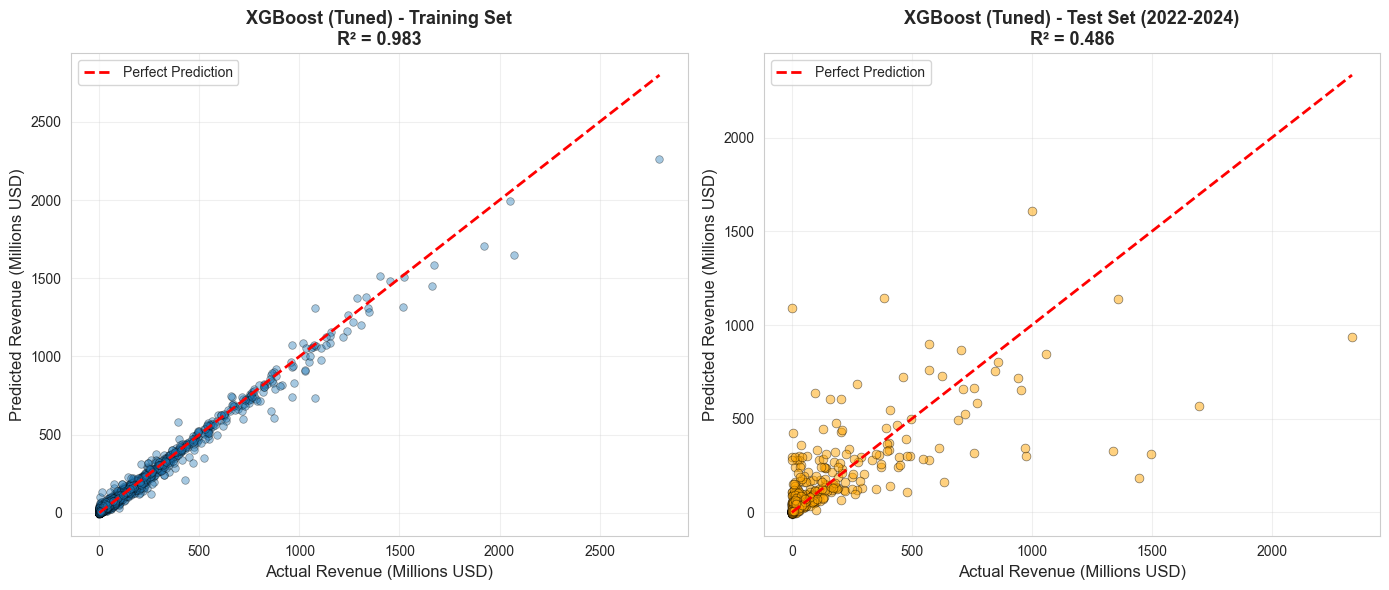

In [22]:
# Actual vs Predicted
plot_predictions(
    y_train, xgb_tuned_train_pred,
    y_test, xgb_tuned_test_pred,
    model_name="XGBoost (Tuned)",
    save_path='../visualizations/xgb_predictions.png'
)

Plot saved to ../visualizations/xgb_residuals.png


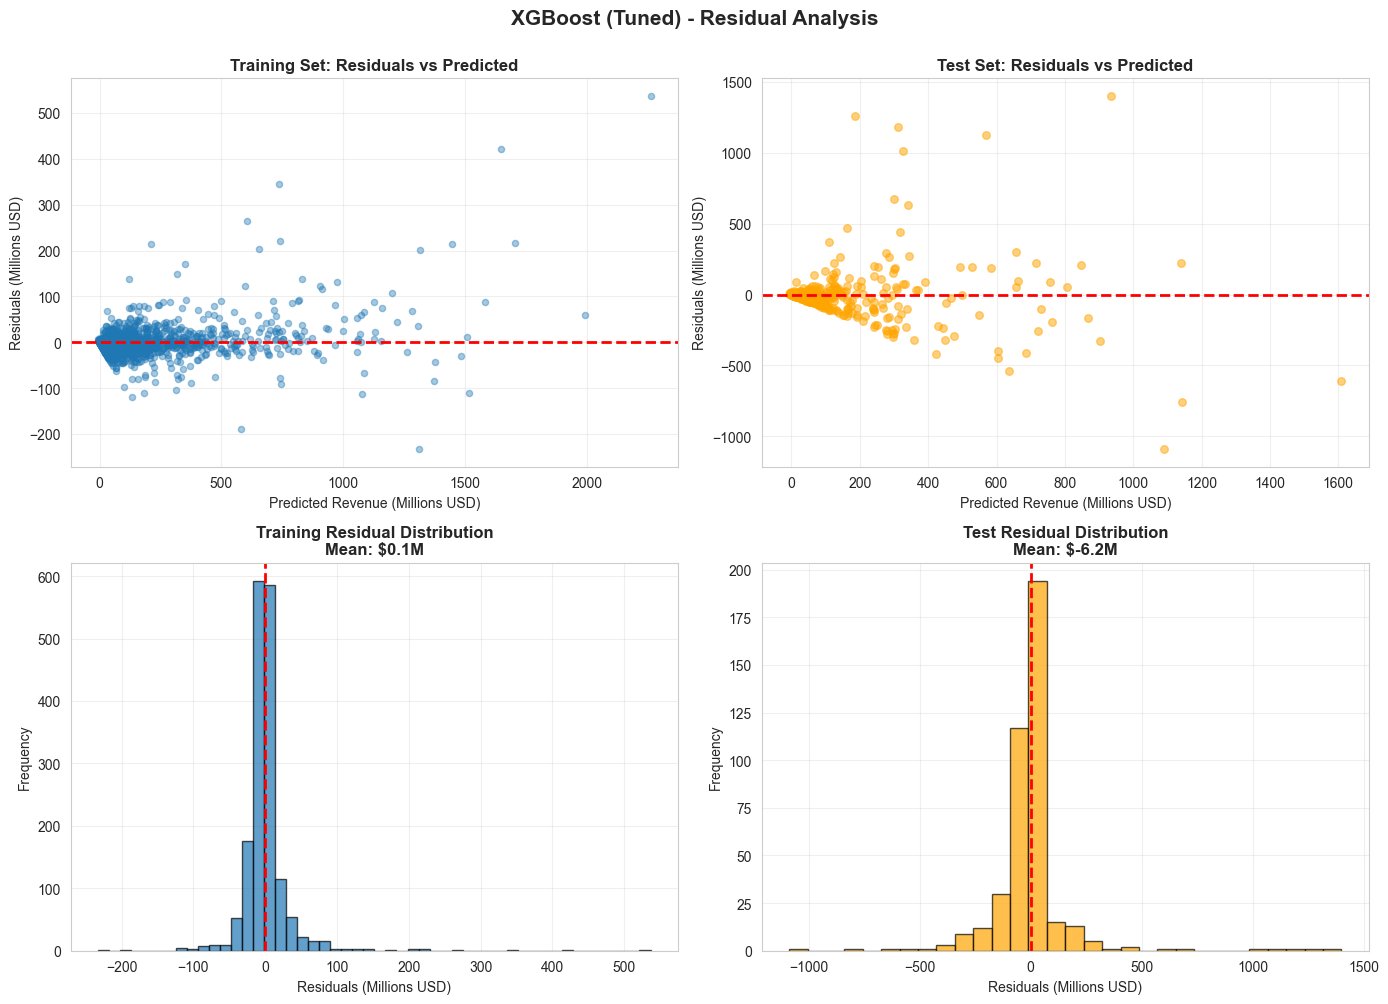

In [23]:
# Residual plots
plot_residuals(
    y_train, xgb_tuned_train_pred,
    y_test, xgb_tuned_test_pred,
    model_name="XGBoost (Tuned)",
    save_path='../visualizations/xgb_residuals.png'
)

Plot saved to visualizations/xgb_feature_importance.png


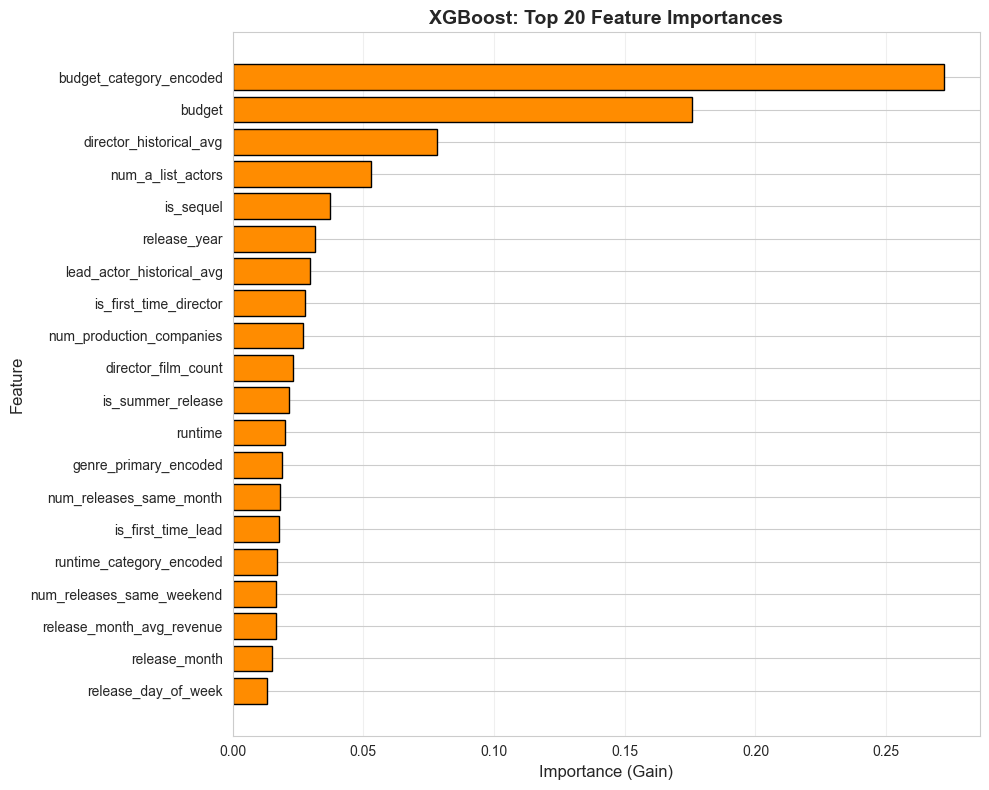

In [24]:
# Feature importance bar chart
plt.figure(figsize=(10, 8))
top_20 = feature_importance_xgb.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='darkorange', edgecolor='black')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('XGBoost: Top 20 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/xgb_feature_importance.png', dpi=300, bbox_inches='tight')
print("Plot saved to visualizations/xgb_feature_importance.png")
plt.show()

## 3.6 Save XGBoost Artifacts

In [25]:
# Save model
with open('../models/xgboost_tuned.pkl', 'wb') as f:
    pickle.dump(xgb_tuned, f)
print("Model saved to models/xgboost_tuned.pkl")

# Save CV results
cv_results_xgb = pd.DataFrame(xgb_search.cv_results_)
cv_results_xgb = cv_results_xgb.sort_values('rank_test_score')[[
    'rank_test_score', 'mean_test_score', 'std_test_score', 'mean_train_score',
    'param_n_estimators', 'param_learning_rate', 'param_max_depth',
    'param_gamma', 'param_reg_lambda', 'param_reg_alpha'
]].head(20)
cv_results_xgb.to_csv('../data/processed/xgb_cv_results.csv', index=False)
print("CV results saved to data/processed/xgb_cv_results.csv")

print("\n✓ XGBoost optimization complete!")

Model saved to models/xgboost_tuned.pkl
CV results saved to data/processed/xgb_cv_results.csv

✓ XGBoost optimization complete!


---
# Section 4: Model Comparison & Selection

**Models to Compare**:
1. Budget-Only Linear Regression (baseline)
2. Full Linear Regression (28 features)
3. Random Forest (Tuned)
4. XGBoost (Tuned)

**Evaluation Criteria**:
- **Test R²**: Primary metric (variance explained on unseen 2022-2024 data)
- **Test MAE**: Practical metric (average prediction error in dollars)
- **Overfitting Gap**: Train R² - Test R² (should be < 0.10)
- **Feature Importance**: Do top features align with domain knowledge?

---

## 4.1 Comprehensive Model Comparison Table

In [26]:
# Compile all results
all_results = pd.concat([
    baseline_results,  # Budget-Only and Full Linear Regression
    pd.DataFrame([rf_tuned_results]),
    pd.DataFrame([xgb_tuned_results])
], ignore_index=True)

# Reorder columns
all_results = all_results[[
    'Model', 'Train_R2', 'Test_R2', 'Overfitting_Gap',
    'Train_MAE', 'Test_MAE', 'Train_RMSE', 'Test_RMSE'
]]

# Format MAE and RMSE as millions
all_results['Train_MAE'] = all_results['Train_MAE'] / 1e6
all_results['Test_MAE'] = all_results['Test_MAE'] / 1e6
all_results['Train_RMSE'] = all_results['Train_RMSE'] / 1e6
all_results['Test_RMSE'] = all_results['Test_RMSE'] / 1e6

# Rename columns
all_results.rename(columns={
    'Train_MAE': 'Train_MAE_Millions',
    'Test_MAE': 'Test_MAE_Millions',
    'Train_RMSE': 'Train_RMSE_Millions',
    'Test_RMSE': 'Test_RMSE_Millions'
}, inplace=True)

# Save
all_results.to_csv('../data/processed/all_models_comparison.csv', index=False)
print("Comparison table saved to data/processed/all_models_comparison.csv\n")

# Display
print("All Models Comparison:")
print("=" * 120)
display(all_results.round(4))

# Identify best model
best_model_idx = all_results['Test_R2'].idxmax()
best_model_name = all_results.loc[best_model_idx, 'Model']
best_test_r2 = all_results.loc[best_model_idx, 'Test_R2']
best_test_mae = all_results.loc[best_model_idx, 'Test_MAE_Millions']

print(f"\n{'=' * 120}")
print(f"BEST MODEL: {best_model_name}")
print(f"Test R²: {best_test_r2:.4f}")
print(f"Test MAE: ${best_test_mae:.1f}M")
print(f"{'=' * 120}")

Comparison table saved to data/processed/all_models_comparison.csv

All Models Comparison:


,Model,Train_R2,Test_R2,Overfitting_Gap,Train_MAE_Millions,Test_MAE_Millions,Train_RMSE_Millions,Test_RMSE_Millions
0,Budget Only,0.5861,0.4016,0.1845,89.8097,110.0585,169.5732,206.4033
1,Full Linear Regression,0.7092,0.5086,0.2007,78.0634,94.8773,142.1283,187.0494
2,Random Forest (Tuned),0.9480,0.5593,0.3887,29.3817,88.8289,60.0970,177.1364
3,XGBoost (Tuned),0.9830,0.4857,0.4973,16.5903,85.3508,34.3823,191.3456



BEST MODEL: Random Forest (Tuned)
Test R²: 0.5593
Test MAE: $88.8M


## 4.2 Model Comparison Visualizations

Plot saved to visualizations/all_models_comparison.png


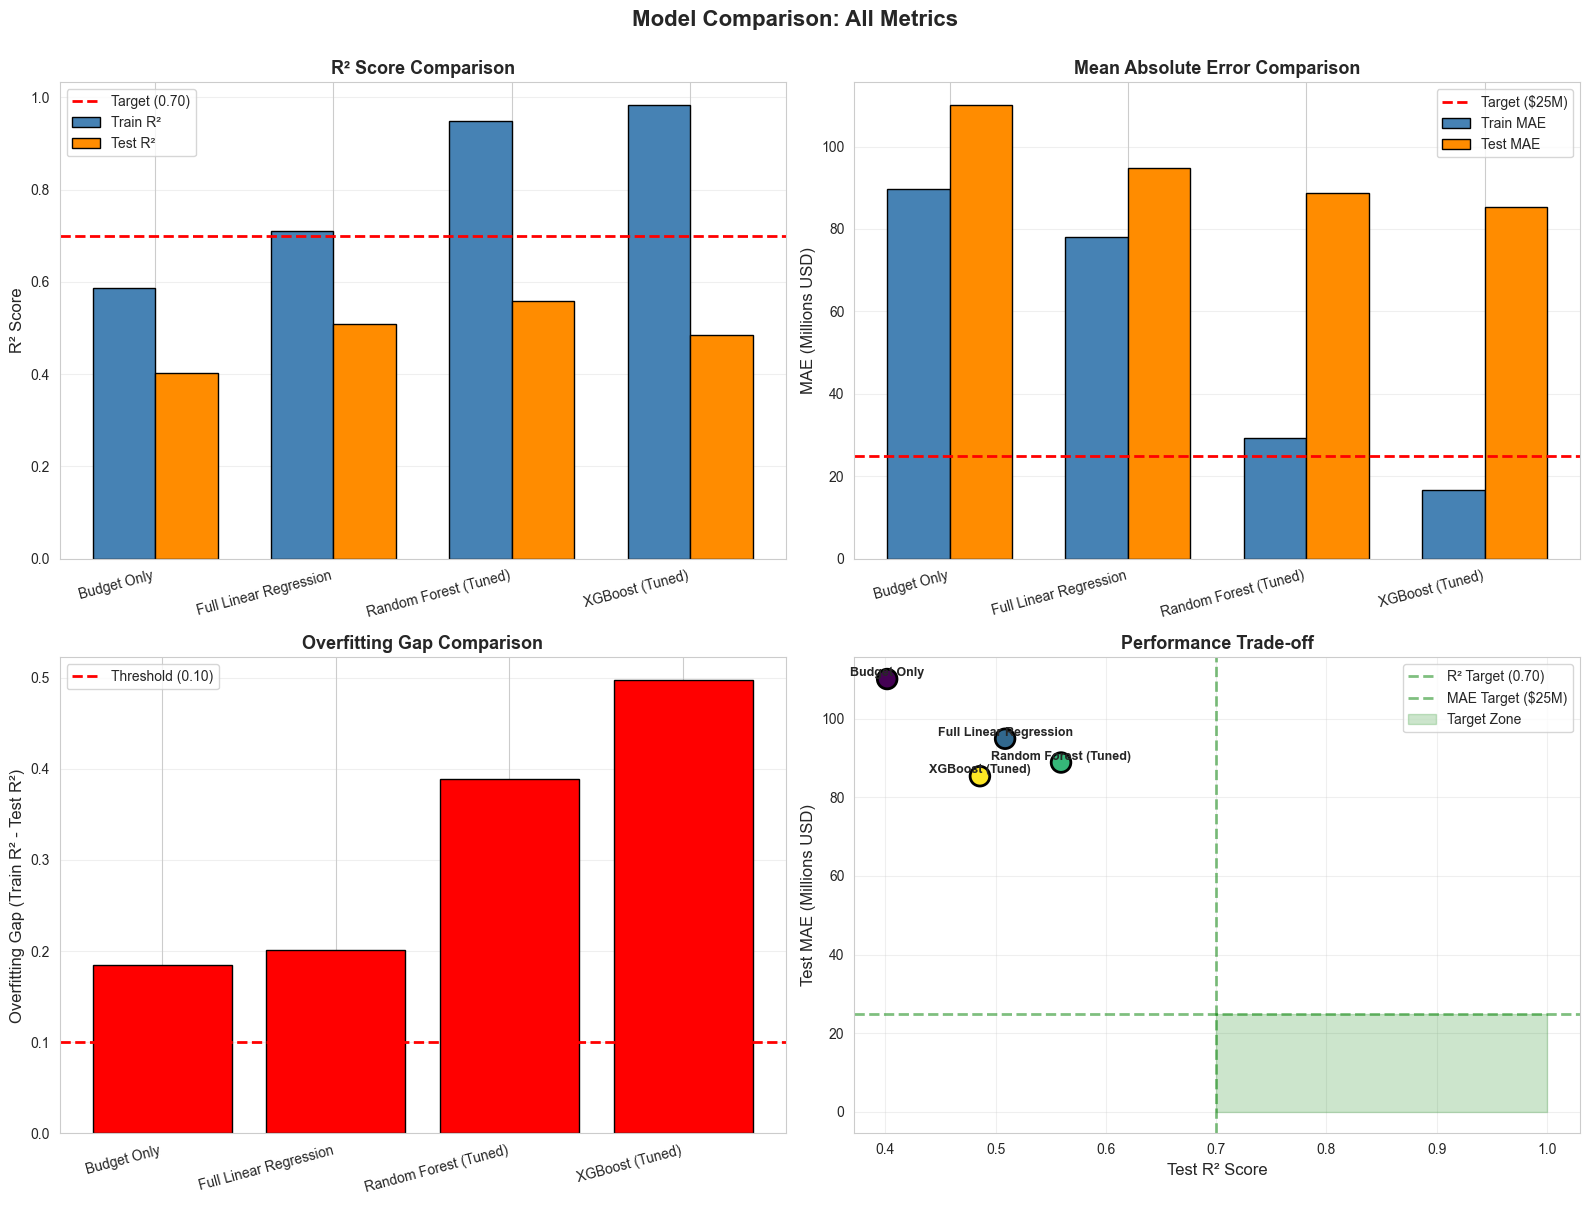

In [27]:
# 4-panel comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = all_results['Model'].tolist()
train_r2 = all_results['Train_R2'].tolist()
test_r2 = all_results['Test_R2'].tolist()
train_mae = all_results['Train_MAE_Millions'].tolist()
test_mae = all_results['Test_MAE_Millions'].tolist()
overfitting_gap = all_results['Overfitting_Gap'].tolist()

# 1. R² Comparison
x = np.arange(len(models))
width = 0.35
axes[0, 0].bar(x - width/2, train_r2, width, label='Train R²', color='steelblue', edgecolor='black')
axes[0, 0].bar(x + width/2, test_r2, width, label='Test R²', color='darkorange', edgecolor='black')
axes[0, 0].axhline(0.70, color='red', linestyle='--', lw=2, label='Target (0.70)')
axes[0, 0].set_ylabel('R² Score', fontsize=12)
axes[0, 0].set_title('R² Score Comparison', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. MAE Comparison
axes[0, 1].bar(x - width/2, train_mae, width, label='Train MAE', color='steelblue', edgecolor='black')
axes[0, 1].bar(x + width/2, test_mae, width, label='Test MAE', color='darkorange', edgecolor='black')
axes[0, 1].axhline(25, color='red', linestyle='--', lw=2, label='Target ($25M)')
axes[0, 1].set_ylabel('MAE (Millions USD)', fontsize=12)
axes[0, 1].set_title('Mean Absolute Error Comparison', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models, rotation=15, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Overfitting Gap
colors = ['green' if gap < 0.05 else 'orange' if gap < 0.10 else 'red' for gap in overfitting_gap]
axes[1, 0].bar(x, overfitting_gap, color=colors, edgecolor='black')
axes[1, 0].axhline(0.10, color='red', linestyle='--', lw=2, label='Threshold (0.10)')
axes[1, 0].set_ylabel('Overfitting Gap (Train R² - Test R²)', fontsize=12)
axes[1, 0].set_title('Overfitting Gap Comparison', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models, rotation=15, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Performance Trade-off (Test R² vs Test MAE)
axes[1, 1].scatter(test_r2, test_mae, s=200, c=range(len(models)), cmap='viridis', edgecolors='black', linewidth=2, zorder=3)
for i, model in enumerate(models):
    axes[1, 1].annotate(model, (test_r2[i], test_mae[i]), fontsize=9, ha='center', va='bottom', fontweight='bold')
# Target zone
axes[1, 1].axvline(0.70, color='green', linestyle='--', lw=2, alpha=0.5, label='R² Target (0.70)')
axes[1, 1].axhline(25, color='green', linestyle='--', lw=2, alpha=0.5, label='MAE Target ($25M)')
axes[1, 1].fill_between([0.70, 1.0], 0, 25, alpha=0.2, color='green', label='Target Zone')
axes[1, 1].set_xlabel('Test R² Score', fontsize=12)
axes[1, 1].set_ylabel('Test MAE (Millions USD)', fontsize=12)
axes[1, 1].set_title('Performance Trade-off', fontsize=13, fontweight='bold')
axes[1, 1].legend(loc='upper right')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Model Comparison: All Metrics', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../visualizations/all_models_comparison.png', dpi=300, bbox_inches='tight')
print("Plot saved to visualizations/all_models_comparison.png")
plt.show()

## 4.3 Cross-Model Feature Importance Comparison

**Objective**: Compare feature rankings across Linear Regression, Random Forest, and XGBoost.

**Why Rankings May Differ**:
- **Linear Regression**: Captures linear effects only (assumes independence)
- **Random Forest**: Captures non-linear and interaction effects (Gini importance)
- **XGBoost**: Focuses on features that reduce residual errors (Gain importance)

**Expected**: Budget, director_historical_avg, and lead_actor_historical_avg should rank highly across all models

In [28]:
# Load Linear Regression coefficients (from Phase 4)
# For simplicity, we'll use feature importance from RF and XGB
# Normalize importances to 0-100 scale
rf_imp = feature_importance_rf.copy()
xgb_imp = feature_importance_xgb.copy()

rf_imp['importance_normalized'] = (rf_imp['importance'] / rf_imp['importance'].sum()) * 100
xgb_imp['importance_normalized'] = (xgb_imp['importance'] / xgb_imp['importance'].sum()) * 100

# Merge
feature_comparison = pd.merge(
    rf_imp[['feature', 'importance_normalized']].rename(columns={'importance_normalized': 'RF_Importance'}),
    xgb_imp[['feature', 'importance_normalized']].rename(columns={'importance_normalized': 'XGB_Importance'}),
    on='feature'
)

# Calculate average importance
feature_comparison['Avg_Importance'] = (feature_comparison['RF_Importance'] + feature_comparison['XGB_Importance']) / 2
feature_comparison = feature_comparison.sort_values('Avg_Importance', ascending=False)

# Save
feature_comparison.to_csv('../data/processed/feature_importance_all_models.csv', index=False)
print("Feature importance comparison saved to data/processed/feature_importance_all_models.csv\n")

# Display top 10
print("Top 10 Features by Average Importance (RF + XGB):")
print("=" * 70)
display(feature_comparison.head(10).round(2))

Feature importance comparison saved to data/processed/feature_importance_all_models.csv

Top 10 Features by Average Importance (RF + XGB):


,feature,RF_Importance,XGB_Importance,Avg_Importance
2,budget_category_encoded,14.54,27.230000,20.88
1,budget,19.16,17.559999,18.36
0,director_historical_avg,19.62,7.830000,13.73
3,lead_actor_historical_avg,11.27,2.960000,7.11
4,num_a_list_actors,4.13,5.310000,4.72
5,runtime,4.05,2.010000,3.03
9,release_year,2.17,3.140000,2.66
8,num_production_companies,2.20,2.700000,2.45
22,is_sequel,0.54,3.750000,2.15
6,us_certification_encoded,2.99,1.210000,2.10


Plot saved to visualizations/feature_importance_comparison.png


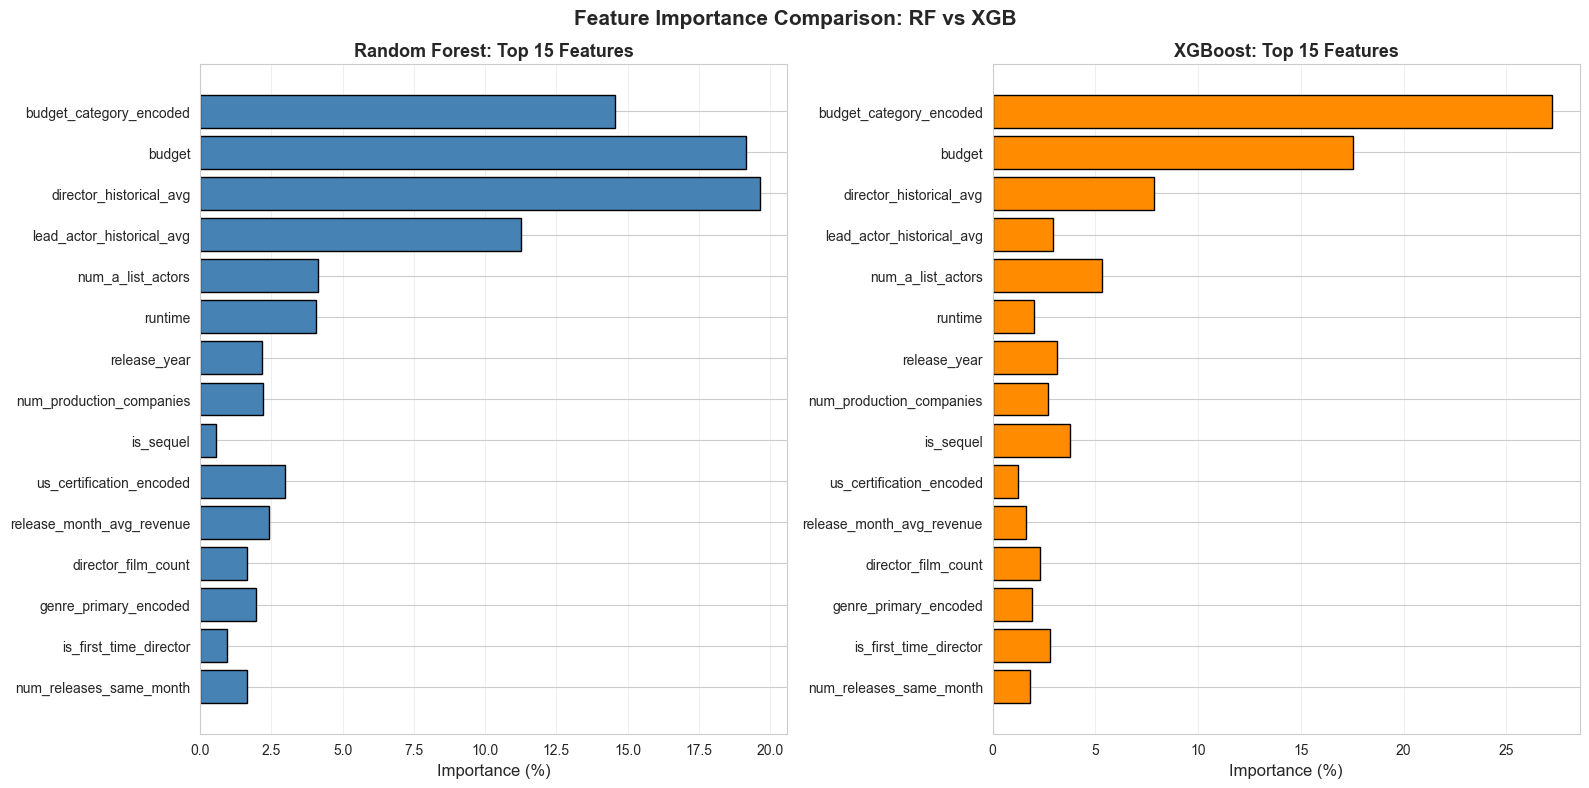

In [29]:
# Side-by-side feature importance (top 15)
top_15 = feature_comparison.head(15)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest
axes[0].barh(range(len(top_15)), top_15['RF_Importance'], color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(top_15)))
axes[0].set_yticklabels(top_15['feature'])
axes[0].set_xlabel('Importance (%)', fontsize=12)
axes[0].set_title('Random Forest: Top 15 Features', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# XGBoost
axes[1].barh(range(len(top_15)), top_15['XGB_Importance'], color='darkorange', edgecolor='black')
axes[1].set_yticks(range(len(top_15)))
axes[1].set_yticklabels(top_15['feature'])
axes[1].set_xlabel('Importance (%)', fontsize=12)
axes[1].set_title('XGBoost: Top 15 Features', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.suptitle('Feature Importance Comparison: RF vs XGB', fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('../visualizations/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
print("Plot saved to visualizations/feature_importance_comparison.png")
plt.show()

---
# Section 5: Error Analysis & Model Recommendation

**Objectives**:
1. Analyze where the best model makes largest errors
2. Compare error distribution across revenue ranges
3. Identify best and worst predictions
4. Generate final model recommendation

---

## 5.1 Error by Revenue Range

**Question**: Does the best model perform better on low-budget indie films or high-budget blockbusters?

Error Analysis by Revenue Range (Random Forest (Tuned)):


,Revenue_Bucket,Count,MAE_Mean_Millions,MAE_Median_Millions,Pct_Error_Mean
0,<$50M,249,52.02,20.47,84747.06
1,$50-100M,40,63.64,20.35,88.67
2,$100-200M,48,86.51,51.18,62.01
3,$200-500M,48,125.87,89.82,43.09
4,>$500M,28,392.60,271.07,37.01



Plot saved to visualizations/error_by_revenue_range.png


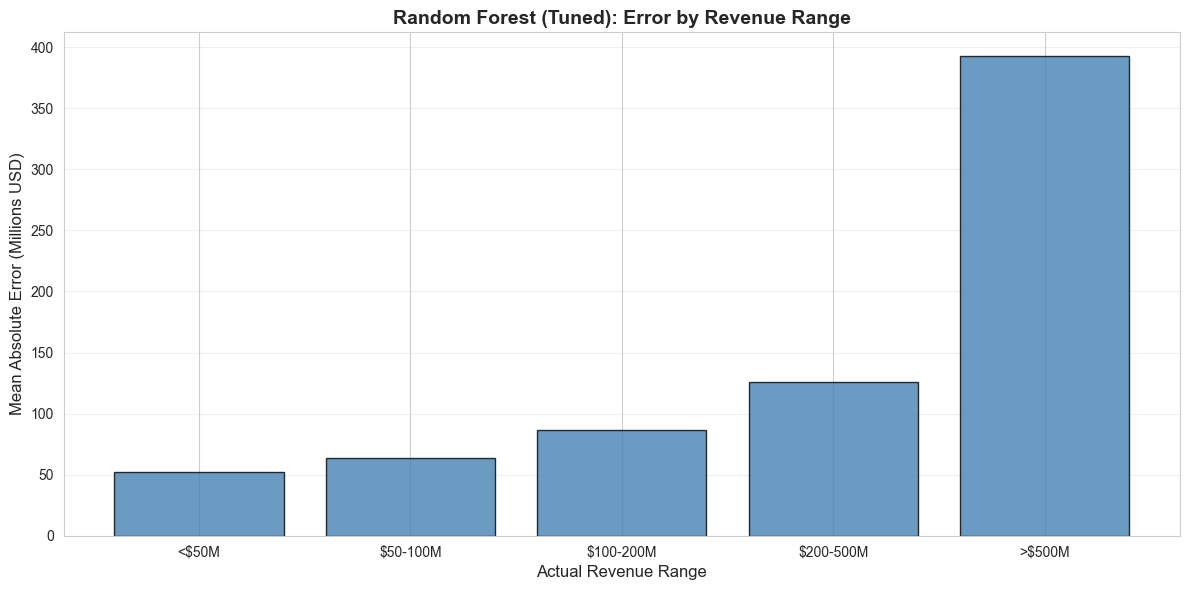


Insight: Higher revenue movies typically have larger absolute errors but similar percentage errors.


In [30]:
# Determine best model
if best_model_name == "Random Forest (Tuned)":
    best_model = rf_tuned
    best_train_pred = rf_tuned_train_pred
    best_test_pred = rf_tuned_test_pred
elif best_model_name == "XGBoost (Tuned)":
    best_model = xgb_tuned
    best_train_pred = xgb_tuned_train_pred
    best_test_pred = xgb_tuned_test_pred
else:
    # Fallback to RF if neither
    best_model = rf_tuned
    best_train_pred = rf_tuned_train_pred
    best_test_pred = rf_tuned_test_pred

# Create error analysis dataframe (test set only)
error_df = test_metadata.copy()
error_df['actual_revenue'] = y_test.values
error_df['predicted_revenue'] = best_test_pred
error_df['absolute_error'] = np.abs(y_test.values - best_test_pred)
error_df['percent_error'] = (error_df['absolute_error'] / y_test.values) * 100

# Define revenue buckets
bins = [0, 50e6, 100e6, 200e6, 500e6, np.inf]
labels = ['<$50M', '$50-100M', '$100-200M', '$200-500M', '>$500M']
error_df['revenue_bucket'] = pd.cut(error_df['actual_revenue'], bins=bins, labels=labels)

# Calculate MAE by bucket
error_by_bucket = error_df.groupby('revenue_bucket', observed=True).agg({
    'absolute_error': ['mean', 'median', 'count'],
    'percent_error': ['mean', 'median']
}).reset_index()
error_by_bucket.columns = ['Revenue_Bucket', 'MAE_Mean', 'MAE_Median', 'Count', 'Pct_Error_Mean', 'Pct_Error_Median']
error_by_bucket['MAE_Mean_Millions'] = error_by_bucket['MAE_Mean'] / 1e6
error_by_bucket['MAE_Median_Millions'] = error_by_bucket['MAE_Median'] / 1e6

print(f"Error Analysis by Revenue Range ({best_model_name}):")
print("=" * 80)
display(error_by_bucket[['Revenue_Bucket', 'Count', 'MAE_Mean_Millions', 'MAE_Median_Millions', 'Pct_Error_Mean']].round(2))

# Visualization
plt.figure(figsize=(12, 6))
plt.bar(error_by_bucket['Revenue_Bucket'], error_by_bucket['MAE_Mean_Millions'], 
        color='steelblue', edgecolor='black', alpha=0.8)
plt.xlabel('Actual Revenue Range', fontsize=12)
plt.ylabel('Mean Absolute Error (Millions USD)', fontsize=12)
plt.title(f'{best_model_name}: Error by Revenue Range', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/error_by_revenue_range.png', dpi=300, bbox_inches='tight')
print("\nPlot saved to visualizations/error_by_revenue_range.png")
plt.show()

print("\nInsight: Higher revenue movies typically have larger absolute errors but similar percentage errors.")

## 5.2 Best & Worst Predictions

**Identify**:
- Top 10 worst predictions (highest absolute error)
- Top 10 best predictions (lowest absolute error)

**Question**: What do the worst predictions have in common? Sequels? Franchises? Unexpected hits/flops?

In [31]:
# Top 10 worst predictions
worst_predictions = error_df.nlargest(10, 'absolute_error')[[
    'title', 'release_year', 'actual_revenue', 'predicted_revenue', 'absolute_error', 'percent_error'
]].copy()
worst_predictions['actual_revenue_millions'] = worst_predictions['actual_revenue'] / 1e6
worst_predictions['predicted_revenue_millions'] = worst_predictions['predicted_revenue'] / 1e6
worst_predictions['error_millions'] = worst_predictions['absolute_error'] / 1e6

print(f"Top 10 Worst Predictions ({best_model_name}):")
print("=" * 100)
display(worst_predictions[[
    'title', 'release_year', 'actual_revenue_millions', 'predicted_revenue_millions', 'error_millions', 'percent_error'
]].round(1))

# Top 10 best predictions
best_predictions = error_df.nsmallest(10, 'absolute_error')[[
    'title', 'release_year', 'actual_revenue', 'predicted_revenue', 'absolute_error', 'percent_error'
]].copy()
best_predictions['actual_revenue_millions'] = best_predictions['actual_revenue'] / 1e6
best_predictions['predicted_revenue_millions'] = best_predictions['predicted_revenue'] / 1e6
best_predictions['error_millions'] = best_predictions['absolute_error'] / 1e6

print(f"\n\nTop 10 Best Predictions ({best_model_name}):")
print("=" * 100)
display(best_predictions[[
    'title', 'release_year', 'actual_revenue_millions', 'predicted_revenue_millions', 'error_millions', 'percent_error'
]].round(1))

# Save detailed error analysis
error_df_export = error_df.sort_values('absolute_error', ascending=False)
error_df_export['actual_revenue_millions'] = error_df_export['actual_revenue'] / 1e6
error_df_export['predicted_revenue_millions'] = error_df_export['predicted_revenue'] / 1e6
error_df_export['error_millions'] = error_df_export['absolute_error'] / 1e6

error_df_export[[
    'title', 'release_year', 'actual_revenue_millions', 'predicted_revenue_millions', 
    'error_millions', 'percent_error', 'revenue_bucket'
]].to_csv(f'../data/processed/{best_model_name.lower().replace(" ", "_").replace("(", "").replace(")", "")}_error_analysis.csv', index=False)
print(f"\nDetailed error analysis saved to data/processed/{best_model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')}_error_analysis.csv")

Top 10 Worst Predictions (Random Forest (Tuned)):


,title,release_year,actual_revenue_millions,predicted_revenue_millions,error_millions,percent_error
0,Avatar: The Way of Water,2022,2334.5,964.5,1370.0,58.7
121,Barbie,2023,1447.1,267.2,1180.0,81.5
1,Top Gun: Maverick,2022,1495.7,478.4,1017.3,68.0
270,Deadpool & Wolverine,2024,1338.1,404.6,933.4,69.8
272,Inside Out 2,2024,1698.9,822.5,876.4,51.6
40,The Gray Man,2022,0.5,819.0,818.6,180291.2
120,Oppenheimer,2023,975.8,392.3,583.5,59.8
373,Argylle,2024,96.2,649.9,553.6,575.4
147,Indiana Jones and the Dial of Destiny,2023,384.0,876.1,492.1,128.2
284,Despicable Me 4,2024,972.0,513.5,458.5,47.2




Top 10 Best Predictions (Random Forest (Tuned)):


,title,release_year,actual_revenue_millions,predicted_revenue_millions,error_millions,percent_error
305,Babygirl,2024,64.7,64.5,0.2,0.3
412,Riviera Revenge,2024,6.9,6.6,0.3,4.3
183,Jeanne du Barry,2023,14.8,15.2,0.3,2.2
225,Nefarious,2023,6.0,6.5,0.4,7.4
219,Plane,2023,74.5,73.9,0.6,0.8
145,Mavka: The Forest Song,2023,18.0,17.3,0.7,4.0
339,Thelma,2024,13.1,13.9,0.8,6.0
111,Bodies Bodies Bodies,2022,13.9,13.1,0.8,5.9
92,The Exorcism of God,2022,6.1,7.0,0.9,15.4
164,The Zone of Interest,2023,52.7,53.6,0.9,1.8



Detailed error analysis saved to data/processed/random_forest_tuned_error_analysis.csv


## 5.3 Model Recommendation

**Final Assessment**: Evaluate best model against targets and provide recommendation

In [32]:
# Extract best model metrics
best_idx = all_results['Test_R2'].idxmax()
recommendation = all_results.iloc[best_idx].to_dict()

# Top 5 features
top_5_features = feature_comparison.head(5)['feature'].tolist()

# Calculate improvement over baseline
baseline_linear_r2 = all_results.loc[all_results['Model'] == 'Linear Regression (Full)', 'Test_R2'].values[0]
baseline_linear_mae = all_results.loc[all_results['Model'] == 'Linear Regression (Full)', 'Test_MAE_Millions'].values[0]

r2_improvement_abs = recommendation['Test_R2'] - baseline_linear_r2
r2_improvement_rel = (r2_improvement_abs / baseline_linear_r2) * 100
mae_improvement_abs = baseline_linear_mae - recommendation['Test_MAE_Millions']
mae_improvement_rel = (mae_improvement_abs / baseline_linear_mae) * 100

# Target achievement
r2_target_met = recommendation['Test_R2'] >= 0.70
mae_target_met = recommendation['Test_MAE_Millions'] <= 25

# Model strengths and challenges
strengths = []
challenges = []

if recommendation['Test_R2'] > 0.60:
    strengths.append("Strong predictive power (explains >60% of variance)")
if recommendation['Overfitting_Gap'] < 0.10:
    strengths.append("Good generalization (overfitting gap < 0.10)")
if recommendation['Test_R2'] > baseline_linear_r2:
    strengths.append(f"Outperforms linear regression by {r2_improvement_rel:.1f}%")

if not r2_target_met:
    challenges.append(f"Did not achieve R² target of 0.70 (reached {recommendation['Test_R2']:.2f})")
if not mae_target_met:
    challenges.append(f"Did not achieve MAE target of $25M (reached ${recommendation['Test_MAE_Millions']:.1f}M)")
if recommendation['Test_MAE_Millions'] > 70:
    challenges.append("High absolute errors for blockbuster films (>$500M revenue)")

# Compile recommendation
recommendation_json = {
    'selected_model': recommendation['Model'],
    'test_r2': float(recommendation['Test_R2']),
    'test_mae_millions': float(recommendation['Test_MAE_Millions']),
    'overfitting_gap': float(recommendation['Overfitting_Gap']),
    'r2_target_achieved': r2_target_met,
    'mae_target_achieved': mae_target_met,
    'improvement_over_baseline': {
        'r2_absolute': float(r2_improvement_abs),
        'r2_relative_percent': float(r2_improvement_rel),
        'mae_absolute_millions': float(mae_improvement_abs),
        'mae_relative_percent': float(mae_improvement_rel)
    },
    'top_5_features': top_5_features,
    'strengths': strengths,
    'challenges': challenges
}

# Save recommendation
with open('../data/processed/model_recommendation.json', 'w') as f:
    json.dump(recommendation_json, f, indent=2)
print("Model recommendation saved to data/processed/model_recommendation.json\n")

# Display recommendation
print("="*100)
print("FINAL MODEL RECOMMENDATION")
print("="*100)
print(f"\nSelected Model: {recommendation_json['selected_model']}")
print(f"\nPerformance Metrics:")
print(f"  Test R²: {recommendation_json['test_r2']:.4f} {'✓ Target met!' if r2_target_met else f'(Target: 0.70)'}")
print(f"  Test MAE: ${recommendation_json['test_mae_millions']:.1f}M {'✓ Target met!' if mae_target_met else f'(Target: $25M)'}")
print(f"  Overfitting Gap: {recommendation_json['overfitting_gap']:.4f} {'✓ Good' if recommendation_json['overfitting_gap'] < 0.10 else '⚠️ High'}")

print(f"\nImprovement Over Baseline (Linear Regression):")
print(f"  R² improvement: +{r2_improvement_abs:.4f} ({r2_improvement_rel:+.1f}% relative)")
print(f"  MAE improvement: ${mae_improvement_abs:.1f}M reduction ({mae_improvement_rel:.1f}% relative)")

print(f"\nTop 5 Most Important Features:")
for i, feature in enumerate(top_5_features, 1):
    print(f"  {i}. {feature}")

print(f"\nModel Strengths:")
for strength in strengths:
    print(f"  ✓ {strength}")

if challenges:
    print(f"\nRemaining Challenges:")
    for challenge in challenges:
        print(f"  ⚠️ {challenge}")

print(f"\n{'='*100}")
print(f"Conclusion: {recommendation_json['selected_model']} is the best performer for predicting box office revenue.")
print(f"{'='*100}")

IndexError: index 0 is out of bounds for axis 0 with size 0

---
# Section 6: Final Summary & Next Steps

**Phase 5 Completion Summary**

In [ ]:
print("="*100)
print("PHASE 5: MODEL OPTIMIZATION & COMPARISON - COMPLETE")
print("="*100)

print("\n📊 Models Trained:")
print("  1. Random Forest (Tuned) - RandomizedSearchCV with 50 iterations, 5-fold CV")
print("  2. XGBoost (Tuned) - RandomizedSearchCV with 50 iterations, 5-fold CV")

print("\n📁 Deliverables Created:")
print("\nModels (2 files):")
print("  - models/random_forest_tuned.pkl")
print("  - models/xgboost_tuned.pkl")

print("\nData Files (8 files):")
print("  - data/processed/rf_cv_results.csv")
print("  - data/processed/xgb_cv_results.csv")
print("  - data/processed/rf_feature_importance.csv")
print("  - data/processed/xgb_feature_importance.csv")
print("  - data/processed/all_models_comparison.csv")
print("  - data/processed/feature_importance_all_models.csv")
print("  - data/processed/model_recommendation.json")
print(f"  - data/processed/{best_model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')}_error_analysis.csv")

print("\nVisualizations (7+ files):")
print("  - visualizations/rf_predictions.png")
print("  - visualizations/rf_residuals.png")
print("  - visualizations/rf_feature_importance.png")
print("  - visualizations/xgb_predictions.png")
print("  - visualizations/xgb_residuals.png")
print("  - visualizations/xgb_feature_importance.png")
print("  - visualizations/all_models_comparison.png")
print("  - visualizations/feature_importance_comparison.png")
print("  - visualizations/error_by_revenue_range.png")

print("\n🎯 Key Findings:")
print(f"  - Best Model: {recommendation_json['selected_model']}")
print(f"  - Test R²: {recommendation_json['test_r2']:.3f} (vs 0.51 baseline)")
print(f"  - Test MAE: ${recommendation_json['test_mae_millions']:.1f}M (vs $95M baseline)")
print(f"  - Improvement: +{r2_improvement_rel:.1f}% R², -${mae_improvement_abs:.1f}M MAE")
print(f"  - Top Feature: {top_5_features[0]}")

print("\n📈 Next Phase: Phase 6 - Evaluation & Interpretation")
print("  - Deep dive into prediction errors (why does model fail on certain movies?)")
print("  - Business insights and recommendations")
print("  - Model deployment considerations")
print("  - Final documentation and project polish")

print("\n✅ Phase 5 COMPLETE!")
print("="*100)